In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

filepath='C:\\Users\\kamin\\Desktop\\IIMA\\SEM-3\\BA\\Project\\'
# tsv_file='pcb_dataset_final.tsv'
# csv_table=pd.read_table(filepath+tsv_file,sep='\t')
#csv_table.to_csv(filepath+'crieto_data.csv',index=False)

In [144]:
df =pd.read_csv(filepath+'crieto_data.csv')

In [243]:
df_Criteo_Attribution=df

In [244]:
df_Criteo_Attribution['day'] = np.floor(df_Criteo_Attribution.timestamp / 86400.).astype(int)

In [245]:
def add_derived_columns(df):
    df_ext = df.copy()
    df_ext['jid'] = df_ext['uid'].map(str) + '_' + df_ext['conversion_id'].map(str)
    
    min_max_scaler = MinMaxScaler()
    for cname in ('timestamp', 'time_since_last_click'):
        x = df_ext[cname].values.reshape(-1, 1) 
        df_ext[cname + '_norm'] = min_max_scaler.fit_transform(x)
    
    return df_ext
df_Criteo_Attribution = add_derived_columns(df_Criteo_Attribution)

Randomly sampling of 10 campaign from 700 to reduce computational complexity

In [246]:
n_campaigns = 10
def sample_campaigns(df, n_campaigns):    
    campaigns = np.random.choice( df['campaign'].unique(), n_campaigns, replace = False )
    return df[ df['campaign'].isin(campaigns) ]

df_Criteo_Attribution = sample_campaigns(df_Criteo_Attribution, n_campaigns)

In [247]:
df_Criteo_Attribution.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat4,cat5,cat6,cat7,cat8,cat9,day,jid,timestamp_norm,time_since_last_click_norm
118,59,29660040,32368244,0,-1,-1,0,0,-1,-1,...,29196072,11409684,1973606,9541873,29196072,29196072,0,29660040_-1,0.000022,0.000000
124,65,1890256,32368244,0,-1,-1,0,0,-1,-1,...,29196072,11409684,5824233,21827104,29196072,29196072,0,1890256_-1,0.000024,0.000000
144,81,12902143,32368244,0,-1,-1,0,1,-1,-1,...,29196072,11409684,28928366,4943804,29196072,29196072,0,12902143_-1,0.000030,0.000000
166,93,2380977,32368244,1,1471679,28647208,0,1,5,8,...,29196072,11409684,30763035,30328882,29196072,29520626,0,2380977_28647208,0.000035,0.056303
201,110,22075924,32368244,0,-1,-1,0,1,-1,-1,...,17152695,11409684,1973606,6266944,29841067,22419790,0,22075924_-1,0.000041,0.000054


# Get number of users who sees the campaign 
Number of impressions per campaign

In [248]:
g1=df_Criteo_Attribution.groupby(['campaign','conversion','click'])['campaign'].count().reset_index(name="count of impressions")
g1.sort_values(by=['campaign'],inplace=True, ascending=False)
g1.to_csv(filepath+'g1_campaign.csv')

In [249]:
g1.tail(100)

,campaign,conversion,click,count of impressions
29,32368244,1,1,36638
28,32368244,0,1,40946
27,32368244,0,0,83472
26,27385784,1,1,146
25,27385784,0,1,5765
24,27385784,0,0,11214
23,26372320,1,1,610
22,26372320,0,1,1315
21,26372320,0,0,3339
20,26091094,1,1,1630


# Filtering journey with more than 2 touchpoints

In [250]:
def filter_journeys_by_length(df, min_touchpoints):
    if min_touchpoints <= 1:
        return df
    else:
        grouped = df.groupby(['jid'])['uid'].count().reset_index(name="count")
        print(grouped)
        return df[df['jid'].isin( grouped[grouped['count'] >= min_touchpoints]['jid'].values )]
df_Criteo_Attribution = filter_journeys_by_length(df_Criteo_Attribution, 2)


                     jid  count
0            10000057_-1      2
1            10000206_-1      1
2             1000030_-1      1
3            10000347_-1      1
4            10000359_-1      1
...                  ...    ...
195137        9998886_-1      1
195138  9998886_29732470      1
195139        9998983_-1      2
195140         999922_-1      1
195141        9999961_-1      1

[195142 rows x 2 columns]


In [251]:
df_Criteo_Attribution.groupby(['jid'])['uid'].count().reset_index(name="count")

,jid,count
0,10000057_-1,2
1,10001412_-1,2
2,10001508_-1,10
3,10001951_-1,2
4,10002025_-1,3
...,...,...
69704,9995529_-1,4
69705,9996693_-1,2
69706,9997934_-1,2
69707,9998771_-1,5


# Balancing dataset for  conversion = 1 and conversion = 0

In [252]:
def balance_conversions(df):
    df_minority = df[df.conversion == 1]
    df_majority = df[df.conversion == 0]
    
    df_majority_jids = np.array_split(df_majority['jid'].unique(), 100 * df_majority.shape[0]/df_minority.shape[0] )
    
    df_majority_sampled = pd.DataFrame(data=None, columns=df.columns)
    for jid_chunk in df_majority_jids:
        df_majority_sampled = pd.concat([df_majority_sampled, df_majority[df_majority.jid.isin(jid_chunk)]])
        if df_majority_sampled.shape[0] > df_minority.shape[0]:
            break
    
    return pd.concat([df_majority_sampled, df_minority]).sample(frac=1).reset_index(drop=True)

df_Criteo_Attribution = balance_conversions(df_Criteo_Attribution)

# One Hot encoding creating dummy variables

In [253]:
def map_one_hot(df, column_names, result_column_name):
    mapper = {} 
    for i, col_name in enumerate(column_names):
        for val in df[col_name].unique():
            mapper[str(val) + str(i)] = len(mapper)
         
    df_ext = df.copy()
    
    def one_hot(values):
        v = np.zeros( len(mapper) )
        for i, val in enumerate(values): 
            v[ mapper[str(val) + str(i)] ] = 1
        return v    
    
    df_ext[result_column_name] = df_ext[column_names].values.tolist()
    df_ext[result_column_name] = df_ext[result_column_name].map(one_hot)
    
    return df_ext

df_Criteo_Attribution = map_one_hot(df_Criteo_Attribution, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8'], 'cats')

df_Criteo_Attribution = map_one_hot(df_Criteo_Attribution, ['campaign'], 'campaigns').sort_values(by=['timestamp_norm'])

In [254]:
len(df_Criteo_Attribution['cats'][1]) # number of features in 10 campaign

127

In [255]:
df_Criteo_Attribution.to_csv(filepath+'crieto_processed_data_10.csv')

# Creating dummy variables for categorical variable in data set

In [256]:
data_prep=df_Criteo_Attribution[[
'campaign',
 'click',
 'cost',
 'cat1',
 'cat2',
 'cat3',
 'cat4',
 'cat5',
 'cat6',
 'cat7',
 'cat8',
 'cat9',
 'day',
 'jid',
'conversion',]]

In [257]:
#creating dummy variables for Categorical columns
data_prep_1 = pd.get_dummies(data_prep.campaign, prefix='campaign')
data_prep_cat_1 = pd.get_dummies(data_prep.campaign, prefix='cat1')
data_prep_cat_2 = pd.get_dummies(data_prep.campaign, prefix='cat2')
data_prep_cat_3 = pd.get_dummies(data_prep.campaign, prefix='cat3')
data_prep_cat_4 = pd.get_dummies(data_prep.campaign, prefix='cat4')
data_prep_cat_5 = pd.get_dummies(data_prep.campaign, prefix='cat5')
data_prep_cat_6 = pd.get_dummies(data_prep.campaign, prefix='cat6')
data_prep_cat_8 = pd.get_dummies(data_prep.campaign, prefix='cat8')
data_prep_cat_9 = pd.get_dummies(data_prep.campaign, prefix='cat9')
data_prep_cat_7 = pd.get_dummies(data_prep.campaign, prefix='cat7')


In [258]:
data_prep=df_Criteo_Attribution[[ 'jid',
 'click',
 'cost',
'conversion',]]

In [259]:
horizontal_stack = pd.concat([data_prep,data_prep_1,data_prep_cat_1,data_prep_cat_2,data_prep_cat_3,data_prep_cat_4,data_prep_cat_5,data_prep_cat_6,data_prep_cat_7,data_prep_cat_8,data_prep_cat_9], axis=1)

In [260]:
horizontal_stack

,jid,click,cost,conversion,campaign_1632450,campaign_3073303,campaign_8695046,campaign_8891880,campaign_16823030,campaign_25920690,...,cat9_1632450,cat9_3073303,cat9_8695046,cat9_8891880,cat9_16823030,cat9_25920690,cat9_26091094,cat9_26372320,cat9_27385784,cat9_32368244
17666,12902143_-1,1,0.000190,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9295,2380977_28647208,1,0.001034,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
54484,22075924_-1,1,0.003502,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5439,28624676_-1,0,0.001267,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
28667,23042801_-1,1,0.000245,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59272,23982140_8841911,1,0.000502,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
56342,30513353_30377343,1,0.002159,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8438,14549073_24487325,1,0.000235,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
62398,477683_18913526,1,0.003456,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [261]:
horizontal_stack.to_csv(filepath+'horizontal_stack_10.csv')

# Number of days between click to conversion

In [262]:
df_Criteo_Attribution['conversion_day'] = np.floor(df_Criteo_Attribution.conversion_timestamp / 86400.).astype(int)
df_Criteo_Attribution['gap_click_sale'] = -1
df_Criteo_Attribution.loc[df_Criteo_Attribution.conversion == 1, 'gap_click_sale'] = df_Criteo_Attribution.conversion_day - df_Criteo_Attribution.day

In [263]:
grouped = df_Criteo_Attribution.groupby(['jid'])['uid'].count().reset_index(name="count")

# Journey length

In [264]:
grouped = df_Criteo_Attribution.groupby(['jid'])['uid'].count().reset_index(name="count")
df_Criteo_Attribution = df_Criteo_Attribution[df_Criteo_Attribution['jid'].isin( grouped[grouped['count'] >= 2]['jid'].values )]

In [265]:
grouped.sort_values(by=['count'],inplace=True, ascending=False)
grouped

,jid,count
7156,21923504_-1,86
513,10852653_-1,84
10728,27904355_-1,77
6577,20899574_-1,75
16915,8977102_-1,71
...,...,...
8242,23684300_13914891,2
8243,23684823_15970611,2
8246,23690505_7393834,2
8252,2370444_21927583,2


# Count the number of touchpoints that lead to conversion for each journey id with conversion =1

In [266]:
grouped[~grouped["jid"].str.contains('_-1')].sort_values(by=['count'],ascending=False)

,jid,count
3849,16340034_25761501,36
4586,17685924_8866261,36
8662,24443173_23699534,36
4553,17655318_16600372,35
2223,1357869_21116868,35
...,...,...
4632,17752303_20111470,2
4626,17745708_14460434,2
4616,17722657_3669061,2
4614,17718358_30269875,2


# Last Touch Attribution Model

In [267]:
def last_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        #print(df['campaigns'].values)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            #print('campaign_id:',campaign_id)
            counters[campaign_id] = counters[campaign_id] + 1   
        return counters
        
    campaign_impressions = count_by_campaign(df)
    print('campaign_impressions',campaign_impressions) 
    df_converted = df[df['conversion'] == 1]
    #print('df_converted',df_converted)
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']
    print('time',df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm'])
    campaign_conversions = count_by_campaign(df_converted[idx])
    print('divide',campaign_conversions / campaign_impressions)   
    return campaign_conversions / campaign_impressions
    
lta = last_touch_attribution(df_Criteo_Attribution)

campaign_impressions [10490. 44808.   862.  8135.  4591.   477.   448.   619.   763.  1520.]
time 9295     False
49400    False
50551    False
72366     True
66792    False
         ...  
59272     True
56342     True
8438     False
62398     True
25990     True
Name: timestamp_norm, Length: 36173, dtype: bool
divide [0.18970448 0.16253794 0.05800464 0.09244007 0.0686125  0.06498952
 0.13616071 0.17609047 0.03407602 0.01842105]


Here are the weights for each campaign

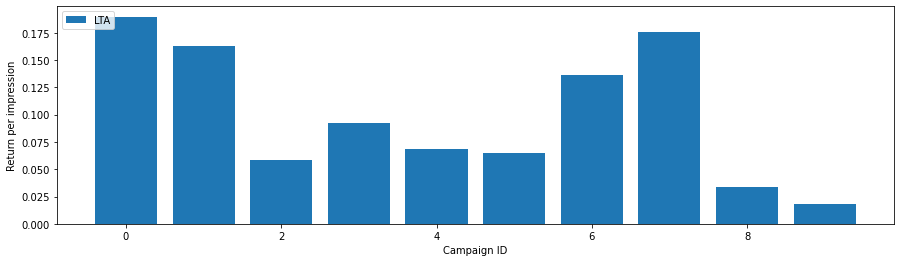

In [269]:
# Visualization of the attribution scores

campaign_idx = range(0,10)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(lta[campaign_idx])), lta[campaign_idx], label='LTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [270]:
lta_1 = pd.DataFrame(lta, columns = ['Value'])
lta_1.head()
lta_1.to_csv(filepath+'lta_10.csv')

# Creating Analytical dataset for logistic regression model.

In [271]:
def features_for_logistic_regression(df):

    def pairwise_max(series):
        #print(np.max(series.tolist(), axis = 0).tolist())
        return np.max(series.tolist(), axis = 0).tolist()
    
    aggregation = {
        'campaigns': pairwise_max,
        'cats': pairwise_max,
        'click': 'sum',
        'cost': 'sum',
        'conversion': 'max'
    }
    
    df_agg = df.groupby(['jid']).agg(aggregation)
    df_agg.to_csv(filepath+'df_agg_10.csv')
    df_agg['features'] = df_agg[['campaigns', 'cats', 'click', 'cost']].values.tolist()
   # print(df_agg['features'])
   # print(df_agg.loc[df_agg.index=='10001624_-1'])
   # print(df_agg['conversion'].values)
   # print(df_agg)
    return (
        np.stack(df_agg['features'].map(lambda x: np.hstack(x)).values),
        df_agg['conversion'].values
    )

In [275]:
x, y = features_for_logistic_regression(df_Criteo_Attribution)
print(np.shape(x))

(17505, 139)


# Logistic regression model

In [276]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20, random_state = 1)

In [277]:
# Quick sanity check
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
y_pred=logisticRegr.predict(x_test)
score = logisticRegr.score(x_test, y_test)
print(score)

0.8217652099400171


C:\Users\kamin\anaconda3\envs\tensor\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [278]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print("Confusion Matrix",cnf_matrix)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Confusion Matrix [[1032  368]
 [ 256 1845]]
Accuracy: 0.8217652099400171
Precision: 0.8337098960686851
Recall: 0.8781532603522132


In [279]:
print('coefficient',logisticRegr.coef_)
print('Intercept',logisticRegr.intercept_)
print('Number of features seen during fit',logisticRegr.n_features_in_)
#print('Names of features seen during fit',logisticRegr.feature_names_in_)

coefficient [[ 2.24557401e-01 -1.08134764e+00 -1.48386263e-01 -1.29921135e+00
  -8.10403584e-01 -1.69329220e-03 -6.07170874e-01 -1.87377860e-01
   9.84337094e-02 -9.29458579e-01  4.31703541e-01 -6.44446443e-01
  -3.97138771e-01 -1.99354379e-01  9.18325193e-02  9.13263226e-02
  -8.78929745e-01 -8.70040668e-01 -2.58129297e-01 -2.22806216e-01
   9.74615192e-01 -1.18389727e-01 -2.01621140e-02  3.92519253e-01
   6.57348982e-02  6.45141020e-01  4.41953076e-01 -5.46955940e-02
   1.41495365e-01 -8.05283652e-02 -1.52687526e-01  9.74957452e-02
   1.41428145e-01 -4.68021122e-01  6.06872840e-01 -1.21888396e-01
  -1.64271285e-01  2.95341974e-01 -3.03319541e-01  4.02618526e-01
  -1.22967075e+00  9.21346657e-01 -1.48386263e-01  6.86570117e-01
   9.11116469e-01  8.38870780e-01 -1.88106493e+00  3.09107047e-01
   9.57110371e-01  4.75961437e-01  3.26123332e-01 -1.05208574e-01
  -1.96155326e+00 -6.47948674e-02 -4.75222909e-01 -1.10785050e+00
   1.35765938e+00  1.10756046e+00 -1.26977780e+00 -1.87377860e-0

Logistic regression returns information in log odds. So you must first convert log odds to odds using np.exp and then take odds/(1 + odds).

To convert to probabilities, use a list comprehension and do the following:

In [280]:
keras_logistic=[np.exp(x)/(1 + np.exp(x)) for x in logisticRegr.coef_[0]]
keras_logistic

[0.5559046268220129,
 0.253251072353464,
 0.46297135232934516,
 0.21429777471207287,
 0.307804501158088,
 0.49957667705191056,
 0.3527048296066876,
 0.4532921163040673,
 0.5245885769286489,
 0.2830345699170403,
 0.6062803848456084,
 0.3442421077642648,
 0.40199997456370457,
 0.450325809624162,
 0.5229420091790239,
 0.5228157249918911,
 0.2933996110414709,
 0.29524583994070436,
 0.43582362394667196,
 0.4445277387177202,
 0.7260384470551198,
 0.4704370900088352,
 0.4949596422531696,
 0.5968890107044824,
 0.5164278094876067,
 0.6559146688162607,
 0.608724311019385,
 0.48632950938546504,
 0.535314941164768,
 0.47987878107178356,
 0.461902105891186,
 0.5243546475824832,
 0.5352982198509932,
 0.3850847244088306,
 0.6472271251257338,
 0.469565571578487,
 0.4590242816897761,
 0.5733034307607423,
 0.42474619492906396,
 0.5993166262418032,
 0.2262390573355908,
 0.7153164168538751,
 0.46297135232934516,
 0.6652034983637424,
 0.7132285724076973,
 0.6982273358700326,
 0.13226660191453238,
 0.576667

# Keras Logistic Regression Model

In [281]:
from keras.models import Sequential 
from keras.layers import Dense, Dropout
from keras.constraints import NonNeg

m = np.shape(x)[1]
    
model1 = Sequential()  
model1.add(Dense(1, input_dim=m, activation='sigmoid', name = 'contributions')) 

model1.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy']) 
history = model1.fit(x_train, y_train, batch_size=64, epochs=20, verbose=1, validation_data=(x_val, y_val)) 
score = model1.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Epoch 1/20
176/176 [==============================] - 0s 1ms/step - loss: 0.6267 - accuracy: 0.6816 - val_loss: 0.5967 - val_accuracy: 0.7026
Epoch 2/20
176/176 [==============================] - 0s 678us/step - loss: 0.5852 - accuracy: 0.7161 - val_loss: 0.5705 - val_accuracy: 0.7230
Epoch 3/20
176/176 [==============================] - 0s 638us/step - loss: 0.5649 - accuracy: 0.7329 - val_loss: 0.5548 - val_accuracy: 0.7365
Epoch 4/20
176/176 [==============================] - 0s 593us/step - loss: 0.5509 - accuracy: 0.7411 - val_loss: 0.5417 - val_accuracy: 0.7444
Epoch 5/20
176/176 [==============================] - 0s 598us/step - loss: 0.5391 - accuracy: 0.7453 - val_loss: 0.5308 - val_accuracy: 0.7465
Epoch 6/20
176/176 [==============================] - 0s 610us/step - loss: 0.5290 - accuracy: 0.7499 - val_loss: 0.5210 - val_accuracy: 0.7540
Epoch 7/20
176/176 [==============================] - 0s 610us/step - loss: 0.5201 - accuracy: 0.7545 - val_loss: 0.5126 - val_accuracy: 0

In [283]:
model1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
contributions (Dense)        (None, 1)                 140       
Total params: 140
Trainable params: 140
Non-trainable params: 0
_________________________________________________________________


Here are the weights for each layer

In [284]:
from sklearn.utils.extmath import softmax
keras_logistic = model1.get_layer('contributions').get_weights()[0].flatten()[0:n_campaigns]
keras_logistic = softmax([keras_logistic]).flatten()
keras_logistic

array([0.14738443, 0.11579642, 0.09450555, 0.09969347, 0.07635804,
       0.09974921, 0.1113278 , 0.11113269, 0.08000406, 0.06404831],
      dtype=float32)

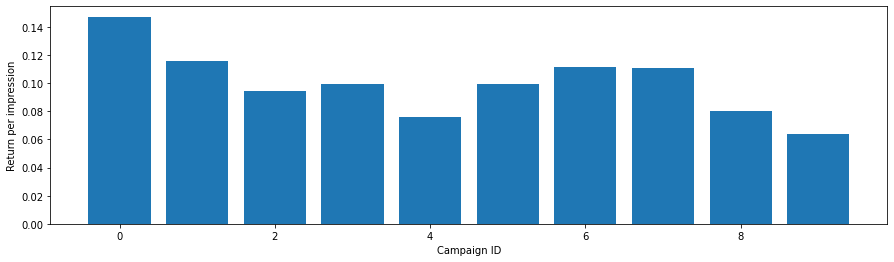

In [285]:
# Visualization of the attribution scores
from sklearn.utils.extmath import softmax

campaign_idx = range(0,10)

keras_logistic = model1.get_layer('contributions').get_weights()[0].flatten()[0:n_campaigns]
keras_logistic = softmax([keras_logistic]).flatten()

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar(range(len(keras_logistic[campaign_idx])), keras_logistic[campaign_idx] )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.show()

In [286]:
np.savetxt(filepath+"logistic_keras_10.txt",keras_logistic)

# Compare LTA and Logistic Regression weights

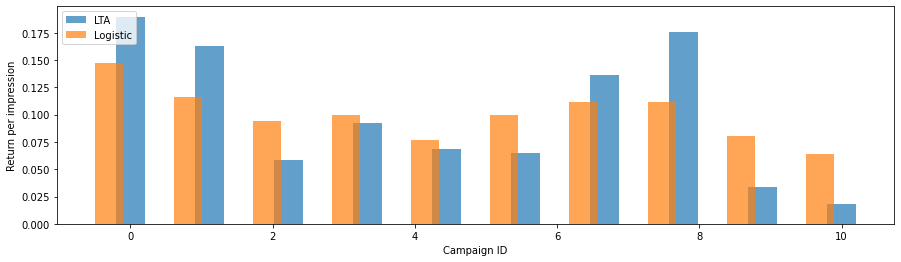

In [287]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)

campaign_idx = range(0,10)

#plt.bar(range(len(keras_logistic[campaign_idx])), keras_logistic[campaign_idx],width=0.4, alpha=0.7,label='Logistic' )
#plt.bar( range(len(lta[campaign_idx])), lta[campaign_idx],width=0.4, alpha=0.7,label='LTA' )
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), lta[campaign_idx], width=0.4, alpha=0.7, label='LTA' )
plt.bar(np.linspace(0, len(keras_logistic[campaign_idx]), len(keras_logistic[campaign_idx])) - 0.3, keras_logistic[campaign_idx], width=0.4, alpha=0.7, label='Logistic' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

# Budget Optimization & Return On Investment

The simulation that we carried out for calculating the ROI can be summarised as below:

Initially, we distributed a limited budget across the different campaigns as per the attribution weights obtained through the models. Then, we replayed the available historical data, in order of their timestamp. If and when the campaign exhausts the limited budget allotted to it, the simulation is stopped and the remaining events associated with it are not replayed. Then, the probabilities of conversion of all journeys affected by this campaign suppression is estimated. 
Finally, we counted the total number of conversions and then estimated ROI. If all the campaigns runs it journey without shortage of money, then the conversion is counted explicitly. Else, the estimate of conversion probability is used. 
We also looked into tuning the parameter(p=pitch). This parameter controls the "pitch" of the budget distribution. (Katsov, 2019). Lesser value of pitch mean more even distribution of budget across different campaign verses higher value denotes more uneven distribution of budget.
Pitch=1 means using the original weights which may not be optimal. Thus, we try out different values of Pitch between 0.5 to 3 to evaluate the ROI with different budget distribution.

Note: For ROI simulation we got the weights of LTA and Logistics regression model by using 400 campaign instead of 10 campaign for a robust output. Below are the ROI based on the same.


In [236]:
def get_campaign_id(x_journey_step):
    return np.argmax(x_journey_step[0:n_campaigns])

In [237]:
np.sum(lta)

50.307788954276496

In [238]:
def simulate_budget_roi(df, budget_total, attribution, verbose=False):
    budgets = np.ceil(attribution * (budget_total / np.sum(attribution)))
    #print("budgets",budgets)
    if(verbose):
        print(budgets)
    
    blacklist = set()
    conversions = set()
    for i in range(df.shape[0]):
        campaign_id = get_campaign_id(df.loc[i]['campaigns']) 
        jid = df.loc[i]['jid']
        if jid not in blacklist:
            if budgets[campaign_id] >= 1:
                budgets[campaign_id] = budgets[campaign_id] - 1
                if(df.loc[i]['conversion'] == 1):
                    conversions.add(jid)
            else:
                blacklist.add(jid)
        
        if(verbose):
            if(i % 10000 == 0):
                print('{:.2%} : {:.2%} budget spent'.format(i/df.shape[0], 1.0 - np.sum(budgets)/budget_total ))
        
        if(np.sum(budgets) < budget_total * 0.02):
            break
            
    return len(conversions.difference(blacklist))

In [239]:
pitches = [0.5, 1.0, 1.5, 2, 2.5, 3]
attributions = [lta,keras_logistic]
        
for i, pitch in enumerate(pitches):
    print('Pitch of Budget Allocation - ' + str(pitch))
    for j, attribution in enumerate(attributions):
        reward = simulate_budget_roi(df_Criteo_Attribution, 10000, attribution**pitch)
        print('{} {} : {}'.format(i, j, reward))

Pitch of Budget Allocation - 0.5
0 0 : 1092
0 1 : 1200
Pitch of Budget Allocation - 1.0
1 0 : 228
1 1 : 1180
Pitch of Budget Allocation - 1.5
2 0 : 304
2 1 : 1117
Pitch of Budget Allocation - 2
3 0 : 368
3 1 : 1115
Pitch of Budget Allocation - 2.5
4 0 : 430
4 1 : 1048
Pitch of Budget Allocation - 3
5 0 : 476
5 1 : 1088


ROI simulation comparison between LTA and Logistic Regression

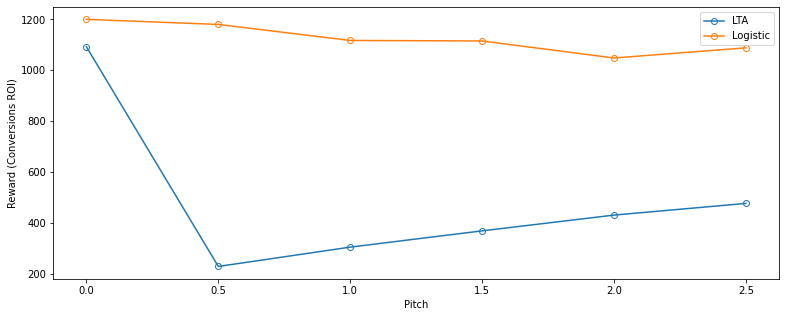

In [242]:
fig = plt.figure(figsize=(13, 5))

campaign_idx = range(0, 6)


ROI_LTA = [1092, 228, 304, 368, 430, 476]
ROI_LTA = np.array(ROI_LTA)


ROI_Logistic = [1200, 1180, 1117, 1115, 1048, 1088]
ROI_Logistic = np.array(ROI_Logistic)


pitch = [0, 0.5, 1, 1.5, 2, 2.5, 3]
pitch = np.array(pitch)


plt.plot(pitch[campaign_idx], ROI_LTA[campaign_idx], label='LTA' , linestyle='-', marker='o', fillstyle=None, 
         markerfacecolor="None")
plt.plot(pitch[campaign_idx], ROI_Logistic[campaign_idx], label='Logistic' , linestyle='-', marker='o', fillstyle=None, 
         markerfacecolor="None")


plt.xlabel('Pitch')
plt.ylabel('Reward (Conversions ROI)')
plt.legend(loc='upper right')
plt.show()